In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch.nn.functional as F


import os
import time
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import skimage.io as io
from skimage.transform import resize

import tensorflow as tf
from tfrecord.torch.dataset import TFRecordDataset

2022-02-25 12:39:28.558636: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# hyperparams
batch_size = 50

# Depth Image Dataset

In [3]:
load_path = "../../../rl_data/saves_1"

In [4]:
class DepthImageDataset(Dataset):
    def __init__(self, load_path=load_path) -> None:
        super(DepthImageDataset, self).__init__()
        
        self.x = torch.empty(0)
        self.nb_images = 0
        self.nb_files = int(len([f for f in os.listdir(load_path) if f.endswith('.p') and os.path.isfile(os.path.join(load_path, f))]) / 5) # five dicts
        print(f"Loading from {load_path}")
        for i in tqdm(range(1)):
            di_load = pickle.load(open(load_path + "/di_dump" + str(i) + ".p", "rb"))
            
            x_ = []
            for ep in di_load.values():
                for image in ep:
                    image = image / 256
                    image = image.transpose(2, 0, 1)
                    image = np.pad(image, [(0,0), (1, 1), (0, 0)], mode='constant', constant_values=0)
                    image_flipped = np.flip(image, 2)
                    x_.append(image)
                    x_.append(image_flipped)

                    self.nb_images += 2

            self.x = torch.cat((self.x, torch.Tensor(np.array(x_))))
    
    def __getitem__(self, index: int):
        return self.x[index]
    
    def __len__(self):
        return self.nb_images

In [5]:
data = DepthImageDataset()

Loading from ../../../rl_data/saves_1


100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.75s/it]


# Dataloader

In [6]:
data_loader = DataLoader(dataset=data, batch_size=batch_size, shuffle=False, num_workers=0)

In [7]:
len(data), len(data_loader)

(2326, 47)

# Test

torch.Size([50, 1, 272, 480])
torch.Size([1, 272, 480])


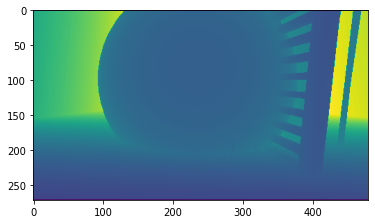

In [8]:
dataiter = iter(data_loader)
images = dataiter.next()
print(images.shape)

image = images[2]
print(image.shape)


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(image)

In [9]:
images.mean()

tensor(0.4118)